# Notebook Setup 
The following cell will install Drake, checkout the manipulation repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  

More details are available [here](http://manipulation.mit.edu/drake.html).

In [1]:
import importlib
import os, sys
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='fa5bcfb6367cd0cfda0e3d11e11854d68b39478a', drake_version='20201118', drake_build='nightly')

from IPython import get_ipython
from IPython.display import display, HTML, clear_output
running_as_notebook = get_ipython() and hasattr(get_ipython(), 'kernel')

import matplotlib.pyplot as plt, mpld3
if running_as_notebook:
  mpld3.enable_notebook()

import numpy as np
import os
from pydrake.all import (RigidTransform, RotationMatrix, BasicVector, LeafSystem, 
                        ConnectPlanarSceneGraphVisualizer, Simulator)
import pydrake.multibody.jupyter_widgets
from manipulation.utils import FindResource
from copy import deepcopy
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions.normal import Normal
from torch.distributions.independent import Independent
from scipy.signal import lfilter
import random

def AddPlanarBinAndManipuland(plant):
  """
    Add the planar manipulation setup
  """
  parser = pydrake.multibody.parsing.Parser(plant)
  bin = parser.AddModelFromFile(FindResource("models/planar_bin.sdf"))
  plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("bin_base", bin),
                   RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,-0.015]))
  planar_joint_frame = plant.AddFrame(
    pydrake.multibody.tree.FixedOffsetFrame(
      "planar_joint_frame",
      plant.world_frame(),
      RigidTransform(RotationMatrix.MakeXRotation(np.pi/2))))
  box = parser.AddModelFromFile(FindResource("models/061_foam_brick.sdf"))
  box_frame = plant.AddFrame(
    pydrake.multibody.tree.FixedOffsetFrame(
      "box_frame", plant.GetFrameByName(
      "base_link", box),
      RigidTransform(RotationMatrix.MakeXRotation(np.pi/2))))
  box_joint = plant.AddJoint(
    pydrake.multibody.tree.PlanarJoint(
    "box_joint", planar_joint_frame, box_frame))
  box_joint.set_default_translation([0, 0.033400])


def AddPlanarGripper(plant):
  """
    Add the planar manipulation gripper
  """
  parser = pydrake.multibody.parsing.Parser(plant)
  parser.package_map().Add(
    "wsg_50_description",
    os.path.dirname(
      pydrake.common.FindResourceOrThrow(
        "drake/manipulation/models/wsg_50_description/package.xml")))
  gripper = parser.AddModelFromFile(
    FindResource("models/schunk_wsg_50_welded_fingers.sdf"), "gripper")
  gripper_body = plant.GetBodyByName("body", gripper)

  # Add a planar joint the old fashioned way (so that I can have three actuators):
  gripper_false_body1 = plant.AddRigidBody(
    "false_body1", gripper,
    pydrake.multibody.tree.SpatialInertia(
      0, [0,0,0], pydrake.multibody.tree.UnitInertia(0,0,0)))
  gripper_false_body2 = plant.AddRigidBody(
    "false_body2", gripper,
    pydrake.multibody.tree.SpatialInertia(
      0, [0,0,0], pydrake.multibody.tree.UnitInertia(0,0,0)))
  gripper_x = plant.AddJoint(pydrake.multibody.tree.PrismaticJoint(
    "gripper_x", plant.world_frame(), plant.GetFrameByName("false_body1"), [1, 0, 0], -.2, .2))
  plant.AddJointActuator("gripper_x", gripper_x)
  gripper_z = plant.AddJoint(pydrake.multibody.tree.PrismaticJoint(
    "gripper_z", plant.GetFrameByName("false_body1"), plant.GetFrameByName("false_body2"), [0, 0, 1], 0.0, 0.3))
  gripper_z.set_default_translation(0.25)
  plant.AddJointActuator("gripper_z", gripper_z)
  gripper_frame = plant.AddFrame(pydrake.multibody.tree.FixedOffsetFrame(
    "gripper_frame", plant.GetFrameByName("body", gripper),
    RigidTransform(RotationMatrix.MakeXRotation(np.pi/2))))
  gripper_theta = plant.AddJoint(pydrake.multibody.tree.RevoluteJoint(
    "gripper_theta", plant.GetFrameByName("false_body2"), gripper_frame, [0, -1, 0],  -np.pi/2, np.pi/2))
  plant.AddJointActuator("gripper_theta", gripper_theta)

  return gripper

def MakePlanarGripperOnlyPlant():
  plant = pydrake.multibody.plant.MultibodyPlant(time_step=0.005)
  AddPlanarGripper(plant)
  plant.Finalize()
  return plant


class StepInput(LeafSystem):
  """provides a step-wise control interface"""
  def __init__(self, u0=None):
    LeafSystem.__init__(self)
    self.DeclareVectorOutputPort('desired_state',
                                 BasicVector(6),
                                 self.DoCalcDesiredState)
    self.u_input = np.zeros(6,)
    if u0 is not None:
      self.update_input(u0)
    
  def DoCalcDesiredState(self, context, output):
    output.SetFromVector(self.u_input)

  def update_input(self, u, mode='abs'):
    if mode == 'abs':
      self.u_input[0:3] = u
    else:
      self.u_input[0:3] = self.u_input[0:3] + u

class PlanarGripperGym(object):
  """
  a gym-like RL environment in Drake. Internally controlled
  by forces/torques (inverse dynamics), the positions are the
  desired positions to the controllers, not hardsetting the positions
  in the simulator.
  """
  def __init__(self,
               render=True,
               render_mode='drake',
               reward_function=None):
    builder = pydrake.systems.framework.DiagramBuilder()
    plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(builder, time_step=0.01)
    AddPlanarBinAndManipuland(plant)
    gripper = AddPlanarGripper(plant)

    plant.Finalize()

    controller_plant =MakePlanarGripperOnlyPlant()
    N = controller_plant.num_positions()
    kp = [100]*N
    ki = [1]*N
    kd = [2*np.sqrt(kp[0])]*N
    controller = builder.AddSystem(pydrake.systems.controllers.InverseDynamicsController(controller_plant, kp, ki, kd, False))
    builder.Connect(plant.get_state_output_port(gripper), controller.get_input_port_estimated_state())
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

    u0 = [0, 0.125, 0]
    step_interface = StepInput(u0=u0)
    builder.AddSystem(step_interface)
    builder.Connect(step_interface.get_output_port(0), controller.get_input_port_desired_state())

    # drake visualizer
    if render:
        self.vis = ConnectPlanarSceneGraphVisualizer(
                    builder,
                    scene_graph,
                    output_port=scene_graph.GetOutputPort("lcm_visualization"),
                    xlim=[-0.3, 0.3],
                    ylim=[-0.1, 0.5],
                    show=False)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    simulator = Simulator(diagram, context)
    simulator.Initialize()

    # important to keep internal variables, otherwise segfault
    # due to potential garbage collection
    self.plant = plant
    self.scene_graph = scene_graph
    self.context = context
    self.controller = controller
    self.controller_plant = controller_plant
    self.step_interface = step_interface
    self.simulator = simulator
    self.builder = builder
    self.gripper = gripper
    self.diagram = diagram
    self.reward_function = reward_function

    # save initial state
    self.u0 = u0
    self.reset()


  def truncate_action(self, du_raw, dp_upper_bound=0.02, dtheta_upper_bound=0.5):
    """Truncate the action to make behaviors more natural

    Args:
        du_raw (numpy.ndarray): the raw control input, before being truncated
        dp_upper_bound (float, optional): the maximum translation allowed in one action
        dtheta_upper_bound (float, optional): the maximum rotation allowed in one action

    Returns:
        du (numpy.ndarray): the truncated action
    The original action is modified in-place. 
    """
    du = deepcopy(du_raw) # ! prevent in-place modification
    # bound movements
    state = self.get_state()
    x, y = state[3:5]
    if x < -0.2 or x > 0.2 or y > 0.35 or y < 0.1:
      # push gripper back towards the center of the env
      du[0:2] = np.array([0, 0.25]) - state[0:2]
    
    theta = state[5]
    unbounded_theta_next = theta + du[2]
    # if unbounded_theta_next > np.pi or unbounded_theta_next < -np.pi/2:
        # du[2] = 0.0
    # truncate action
    pos_mag = np.linalg.norm(du[0:2])
    if pos_mag > dp_upper_bound:
      du[0:2] = du[0:2] / pos_mag * dp_upper_bound
    if abs(du[2]) > dtheta_upper_bound:
      du[2] = dtheta_upper_bound * np.sign(du[2])
    return du

  def step(self, du, dt=0.2, dp_upper_bound=0.01, dtheta_upper_bound=0.1):
    # limit the magnitude of the position change and angle change
    self.step_interface.update_input(du, 'rel')
    past_state = self.get_state()
    try:
        self.simulator.AdvanceTo(self.context.get_time() + dt)
    except:
        return

    current_state = self.get_state()
    reward, done, info = self.reward_function(current_state)
    return self.get_state(), reward, done, info

  def simulate(self, dt):
    self.simulator.AdvanceTo(self.context.get_time() + dt)

  def reset(self):
    self.simulator.Initialize()
    initial_pv = np.array([ 0., 0.,  0,  0.,
        0.125,  0.0, 0.0,  0.0,
        0.0,  0.0,  0.0,  0.0])
    plant_context = self.plant.GetMyMutableContextFromRoot(self.context)
    self.plant.SetPositionsAndVelocities(plant_context, initial_pv)
    self.step_interface.update_input(self.u0, 'abs')
    self.simulator.AdvanceTo(self.context.get_time() + 2.0)
    return self.get_state()

  def get_state(self, mode='p'):
    """
    mode: 'p', 'v, 'pv'
    """
    plant_context = self.plant.GetMyContextFromRoot(self.context)
    pos_vel = self.plant.GetPositionsAndVelocities(plant_context)
    if mode == 'p':
      return deepcopy(pos_vel[0:6])
    elif mode == 'v':
      return deepcopy(pos_vel[6:])
    else:
      return deepcopy(pos_vel)

def pad_to_last(nums, total_length, axis=-1, val=0):
    """Pad val to last in nums in given axis.

    length of the result in given axis should be total_length.

    Raises:
      IndexError: If the input axis value is out of range of the nums array

    Args:
        nums (numpy.ndarray): The array to pad.
        total_length (int): The final width of the Array.
        axis (int): Axis along which a sum is performed.
        val (int): The value to set the padded value.

    Returns:
        torch.Tensor: Padded array

    """
    tensor = torch.Tensor(nums)
    axis = (axis + len(tensor.shape)) if axis < 0 else axis

    if len(tensor.shape) <= axis:
        raise IndexError('axis {} is out of range {}'.format(
            axis, tensor.shape))

    padding_config = [0, 0] * len(tensor.shape)
    padding_idx = abs(axis - len(tensor.shape)) * 2 - 1
    padding_config[padding_idx] = max(total_length - tensor.shape[axis], val)
    return F.pad(tensor, padding_config)


def filter_valids(tensor, valids):
    """Filter out tensor using valids (last index of valid tensors).

    valids contains last indices of each rows.

    Args:
        tensor (torch.Tensor): The tensor to filter
        valids (list[int]): Array of length of the valid values

    Returns:
        torch.Tensor: Filtered Tensor

    """
    return [tensor[i][:valid] for i, valid in enumerate(valids)]

def discount_cumsum(x, discount):
    """Discounted cumulative sum.

    See https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#difference-equation-filtering  # noqa: E501
    Here, we have y[t] - discount*y[t+1] = x[t]
    or rev(y)[t] - discount*rev(y)[t-1] = rev(x)[t]

    Args:
        x (np.ndarrary): Input.
        discount (float): Discount factor.

    Returns:
        np.ndarrary: Discounted cumulative sum.


    """
    return lfilter([1], [1, float(-discount)], x[::-1],
                                axis=0)[::-1]

class BatchDataset:
    def __init__(self, inputs, batch_size, extra_inputs=None):
        self._inputs = [i for i in inputs]
        if extra_inputs is None:
            extra_inputs = []
        self._extra_inputs = extra_inputs
        self._batch_size = batch_size
        if batch_size is not None:
            self._ids = np.arange(self._inputs[0].shape[0])
            self.update()

    @property
    def number_batches(self):
        if self._batch_size is None:
            return 1
        return int(np.ceil(self._inputs[0].shape[0] * 1.0 / self._batch_size))

    def iterate(self, update=True):
        if self._batch_size is None:
            yield list(self._inputs) + list(self._extra_inputs)
        else:
            for itr in range(self.number_batches):
                batch_start = itr * self._batch_size
                batch_end = (itr + 1) * self._batch_size
                batch_ids = self._ids[batch_start:batch_end]
                batch = [d[batch_ids] for d in self._inputs]
                yield list(batch) + list(self._extra_inputs)
            if update:
                self.update()

    def update(self):
        np.random.shuffle(self._ids)
        
class MLPGaussian(nn.Module):
    def __init__(self, 
                input_dim=7,
                output_dim=6,
                num_hidden=2,
                hidden_dim=128,
                nonlinear_act=nn.ReLU,
                hidden_w_init=nn.init.xavier_normal_,
                hidden_b_init=nn.init.zeros_,
                output_w_inits=nn.init.xavier_normal_,
                output_b_inits=nn.init.zeros_):
        super(MLPGaussian, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.act = nonlinear_act()
        self.fc_list = nn.ModuleList()
        for i in range(num_hidden - 1):
            hidden_layer = nn.Linear(hidden_dim, hidden_dim)
            hidden_w_init(hidden_layer.weight)
            hidden_b_init(hidden_layer.bias)
            self.fc_list.append(hidden_layer)
        
        self.fc_out_mean = nn.Linear(hidden_dim, output_dim)
        self.fc_out_var = nn.Linear(hidden_dim, output_dim)

        output_w_inits(self.fc_out_mean.weight)
        output_b_inits(self.fc_out_mean.bias)

    def forward(self, x):
        # out = x.view(-1, self.input_dim)
        out = self.fc_in(x)
        out = self.act(out)
        for _, layer in enumerate(self.fc_list, start=0):
            out = layer(out)
            out = self.act(out)
        out_mean = self.fc_out_mean(out)
        out_var = self.fc_out_var(out)
        out_var = self.act(out_var)
        out_var = out_var + 0.001 # add a small bias to make sure it is not equal to 0
        # return (out_mean, out_var)
        return out_mean

    
def init_path():
    path_sample = {'observations': [],
                    'next_observations': [],
                    'actions': [],
                    'rewards': [],
                    'infos': []}
    return path_sample


class REINFORCE:
    def __init__(self,
                 env,
                 policy,
                 value_function,
                 util_compute_policy_loss,
                 util_compute_value_loss,
                 util_compute_advantage,
                 use_advantage=False,
                 gae_lambda=1.0,
                 max_episode_length=100,
                 discount_ratio=0.99,
                 learning_rate=0.01):

        self.env = env
        self.max_episode_length = max_episode_length
        self.discount = discount_ratio
        self._gae_lambda = gae_lambda
        self.util_compute_policy_loss = util_compute_policy_loss
        self.util_compute_value_loss = util_compute_value_loss
        self.util_compute_advantage = util_compute_advantage
        self.use_advantage = use_advantage
        
        self.policy = policy
        self._value_function = value_function
        self._policy_optimizer = torch.optim.Adam(self.policy.parameters(),
                                                  lr=learning_rate)
        self._vf_optimizer = torch.optim.Adam(self._value_function.parameters(),
                                                lr=learning_rate)
        
    
    def _process_samples(self, paths):
        r"""Process sample data based on the collected paths.

        Notes: P is the maximum episode length (self.max_episode_length)

        Args:
            paths (list[dict]): A list of collected paths

        Returns:
            torch.Tensor: The observations of the environment
                with shape :math:`(N, P, O*)`.
            torch.Tensor: The actions fed to the environment
                with shape :math:`(N, P, A*)`.
            torch.Tensor: The acquired rewards with shape :math:`(N, P)`.
            list[int]: Numbers of valid steps in each paths.
            torch.Tensor: Value function estimation at each step
                with shape :math:`(N, P)`.

        """
        valids = torch.Tensor([len(path['actions']) for path in paths]).int()
        obs = torch.stack([
            pad_to_last(path['observations'],
                        total_length=self.max_episode_length,
                        axis=0) for path in paths
        ])
        actions = torch.stack([
            pad_to_last(path['actions'],
                        total_length=self.max_episode_length,
                        axis=0) for path in paths
        ])
        rewards = torch.stack([
            pad_to_last(path['rewards'], total_length=self.max_episode_length)
            for path in paths
        ])
        returns = torch.stack([
            pad_to_last(discount_cumsum(path['rewards'], self.discount).copy(),
                        total_length=self.max_episode_length) for path in paths
        ])
        with torch.no_grad():
            baselines = self._value_function(obs)

        return obs, actions, rewards, returns, valids, baselines
    
    def collect_paths(self,
                    process_action=None,
                    batch_size=100,
                    max_episode_length=100):
        """
        Args:
            env: simulation environment (e.g.Gym)
            batch_size (int, optional): the number of episodes to be included in one patch.
                                        Defaults to 100.
            max_episode_length (int, optional): the maximum episode length
        Returns:
            [list]: a list of dicts, each dict stores data of one episode
        """
        env = self.env
        paths = []
        invalid_episode_count = 0
        while len(paths) < batch_size:
            st= env.reset()
            this_path = init_path()
            good_episode = True

            for t in range(max_episode_length):
                # take a step
                at, _ = self.policy.get_action(st)
                if process_action is not None:
                    at = process_action(at)
                es = env.step(at)
                if es is not None:
                    st2, reward, done, info = es
                    # env.render()
                    this_path['observations'].append(st)
                    this_path['next_observations'].append(st2)
                    this_path['actions'].append(at)
                    this_path['rewards'].append(reward)
                    this_path['infos'].append(info)
                else:
                    ## discard this episode if the 
                    ## simulation/integration fails
                    ## this is because the time step
                    ## in our simulation
                    ## plant's  is considerably 
                    ## large (0.01), in order to 
                    ## speed up simulation.
                    good_episode = False
                    invalid_episode_count += 1
                    break

                if done:
                    break
                st = st2
            if good_episode:
                for key in this_path.keys():
                    this_path[key] = np.c_[this_path[key]]
                this_path['rewards'] = this_path['rewards'].squeeze()
                paths.append(this_path)
        return paths
    
    def get_mini_batch_data(self, *inputs):
        """mini batch training data generator"""
        batch_dataset = BatchDataset(inputs, None)
        for _ in range(1):
            for dataset in batch_dataset.iterate():
                yield dataset

    def train_from_episode_batch(self, itr, paths):
        """Train the algorithm from an episode batch

        Args:
            itr (int): Iteration number.
            paths (list[dict]): A list of collected paths.

        Returns:
            numpy.float64: Calculated mean value of undiscounted returns.

        """
        # the individual paths are not of the same length, 
        # the length of the paths are stored in valids
        
        obs, actions, rewards, returns, valids, baselines = \
            self._process_samples(paths)
        obs_flat = torch.cat(filter_valids(obs, valids))
        actions_flat = torch.cat(filter_valids(actions, valids))
        rewards_flat = torch.cat(filter_valids(rewards, valids))
        returns_flat = torch.cat(filter_valids(returns, valids))
        advs_flat = self._compute_advantage(rewards, valids, baselines)

        value_loss, policy_loss = 0., 0.
        if self.use_advantage:
            for dataset in self.get_mini_batch_data(
                    obs_flat, actions_flat, advs_flat):
                policy_loss = self._train_policy(*dataset)
        else:
            for dataset in self.get_mini_batch_data(
                    obs_flat, actions_flat, returns_flat):
                policy_loss = self._train_policy(*dataset)

        for dataset in self.get_mini_batch_data(obs_flat, returns_flat):
            value_loss = self._train_value_function(*dataset)

        mean_episode_lengths = np.mean(valids.numpy())
        undiscounted_returns = list(torch.sum(rewards, dim=1).numpy())

        total_reward = float(float(rewards_flat.sum()))

        print(f'{itr}, total reward:{total_reward:.3f}, policy_loss:{policy_loss:.3f}, value_loss:{value_loss:.3f}, mean episode length:{mean_episode_lengths}')
        
        return total_reward, mean_episode_lengths, policy_loss, value_loss

    def _train_policy(self, obs, actions, returns):
        self._policy_optimizer.zero_grad()
        loss = self.compute_policy_loss(obs, actions, returns)
        loss.backward()
        self._policy_optimizer.step()
        return loss

    def _train_value_function(self, obs, returns):
        self._vf_optimizer.zero_grad()
        loss = self.util_compute_value_loss(self._value_function, obs, returns)
        loss.backward()
        self._vf_optimizer.step()
        return loss

    def compute_policy_loss(self, obs, actions, returns):
        """call student's implementation"""
        loss = self.util_compute_policy_loss(self.policy, obs, actions, returns)
        return loss
    

    def _compute_advantage(self, rewards, valids, baselines):
        """compute the advantage function

        Args:
            rewards (torch.tensor): the episodic rewards, batch_size x max episode length
            valids (torch.tensor): valid episodic lengths
                    to allow concatenation of episodes of different lengths,
                    by default, the max episode length is used instead of 
                    the actual episode lengths to construct reward and 
                    baseline tensors 
            baselines (torch.tensor): estimated baselines (state values) 
                                      batch_size x max episode length

        Returns:
            [torch.tensor]: flattened advantage function
        """
        advantages = self.util_compute_advantage(self.discount, self._gae_lambda,
                                        self.max_episode_length, baselines,
                                        rewards)
        advantage_flat = torch.cat(filter_valids(advantages, valids))

        return advantage_flat

def draw_training_stats(training_stats,
                        title):
    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,10))
    axes = [ax1, ax2, ax3, ax4]
    ax1.plot(training_stats['total_reward'], 'o-', label='total_rewards')
    ax2.plot(training_stats['policy_loss'], 'o-', label='policy_loss')
    ax3.plot(training_stats['value_loss'], 'o-', label='value_loss')
    ax4.plot(training_stats['avg_episode_length'], 'o-', label='avg_episode_length')
    ax1.set_title(title)
    for ax in axes:
        ax.legend()
    axes[-1].set_xlabel('# of episodes')

    ax3.set_yscale('log')
    ax2.set_yscale('log')

def visualize_policy(reward_function, policy=None):
    env = PlanarGripperGym(render=True,
                           reward_function=reward_function)
    st = env.reset()
    env.vis.start_recording()
    for i in range(10):
        st = env.get_state()
        at = None
        if policy is None:
            at = np.random.rand(3,) * 0.1 - 0.05
            at = env.truncate_action(at)
        else:
            at, _ = algo.policy.get_action(st)
        at = env.truncate_action(at)
        env.step(at)

    env.vis.stop_recording()
    ani = env.vis.get_recording_as_animation(repeat=True)
    display(HTML(ani.to_jshtml()))

Cloning into '/opt/manipulation'...

Note: checking out 'fa5bcfb6367cd0cfda0e3d11e11854d68b39478a'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at fa5bcfb Merge pull request #111 from hjsuh94/rl/sets

+ [[ 0 -ne 0 ]]
+ command -v conda
+ apt-get update -qq
+ apt-get install -o APT::Acquire::Retries=4 -o Dpkg::Use-Pty=0 -qy --no-install-recommends lsb-release
++ lsb_release -cs
+ [[ bionic != \b\i\o\n\i\c ]]
+ apt-get install -o APT::Acquire::Retries=4 -o Dpkg::Use-Pty=0 -qy --no-install-recommends ca-certificates gnupg
+ APT_KEY_DONT_WARN_ON_DANGEROUS_USAGE=1
+ apt-key adv -q --fetch-keys https://bazel.build/bazel-releas

# REINFORCE
In the lecture, you have been introduced to the idea of policy gradient, where the objective is to find a direct mapping from states to actions. In this exercise, you will implement REINFORCE, also commonly referred to as Vanilla Policy Gradient (VPG) method, to solve simple manipulation problems. To finish this exercise, you need to complete the 3 steps listed below:

1. Implement the method to compute the loss of the policy function
2. Implement the method to compute the loss of the value function
3. Implement the method to compute the advantage function

Now let's check out the manipulation problem you are going to solve! The objective of the problem is to manipulate the foam block in the scene to maximize its $x$ coordinate. We intentionally make this problem extremely simple to help you train and debug faster. If you would like to solve a more difficult task, you are welcome to modify the reward function defined in the cell below. Note that since REINFORCE is an on-policy method, it is not known for being data efficient, so expect longer training time depending on how difficult your task is.

In [2]:
def reward_function(observation):
    """
    observation = [block_x, block_z, block_theta,
                   gripper_x, gripper_z, gripper_theta]
    """
    
    # compute dense rewards
    block_angle = observation[2]
    gripper_angle = observation[5]

    reward = observation[0]
    done = False
    if observation[0] > 0.1:
        done = True
        reward = 100. # reward goal completion
    info = {} 
    # print(block_angle)
    return reward, done, info

if running_as_notebook:
    visualize_policy(reward_function, None)

In this exercise, we use the Markov Decision Process (MDP) formulation. We assume we have the full access to the poses of the gripper and foam block. In the following sections, we use states and observations interchangeably, both referring to the concatenation of block pose and gripper pose. 

## Review of REINFORCE Algorithm

**REINFORCE** (Monte-Carlo policy gradient) relies on an estimated return by Monte-Carlo methods using episode samples to update the policy parameter $\theta$. REINFORCE works because the expectation of the sample gradient is equal to the actual gradient:

$$
\nabla_\theta J(\theta)  = \mathbb{E}_{\pi_\theta} [\nabla_\theta \ln \pi_\theta (x_t, u_t) Q^{\pi_\theta}(x_t, u_t) ]
$$


where $\pi_\theta$ is the policy parameterized by $\theta$, and the action distribution computed from the policy is $\pi_\theta(u_t, x_t) = p_{\pi_\theta}(u_t \vert x_t)$. Since $Q^{\pi_\theta}(x_t, u_t)$ is unknown, we instead use unbiased samples to approximate it 

$$ Q^\pi(x_t, u_t) = \mathbb{E}_\pi[G_t \vert x_t, u_t] $$

where $G_t$ is the returns computed from samples


Therefore we can measure $G_t$ from real sample trajectories and use that to update our policy gradient. It relies on a full trajectory and that’s why it is a Monte-Carlo method.

The REINFORCE algorithm is quite straightforward:

Initialize the policy parameter $\theta$ at random.

Generate one trajectory on policy $\pi_\theta: x_1, u_1, r_2, x_2, u_2, \dots, x_t$

For t=1, 2, … , T:

1. Estimate the the return $G_t= \sum_{t=0}^{T} \alpha^t R_t$

2. Update policy parameters: $\theta \leftarrow \theta + \alpha \nabla_\theta \ln \pi_\theta(x_t, u_t)G_t$, where $\alpha$ is the learning rate


A widely used variation of REINFORCE is to subtract a baseline value from the return $G_t$ to reduce the variance of gradient estimation while keeping the bias unchanged (Remember we always want to do this when possible). 

To implement REINFORCE algorithm to solve continuous control tasks, you will inevitably need function approximators to estimate the policy distribution and optionally value function if an advantage function is used instead of the total discounted rewards for $G_t$. To help you quickly get to the core of the algorithm, we have provided you the implementation of the majority parts of the algorithm. You may find these codes in the `REINFORCE`, `PolicyEstimator`, `ValueEstimator` classes from setup cell. Note that for this exercise, you are not required to fully understand these codes.

In [3]:
class PolicyEstimator(nn.Module):
    def __init__(self,
                 num_hidden,
                 hidden_dim,
                 obs_dim = None,
                 action_dim = None,
                 nonlinear_act=nn.Tanh,
                 init_std = 1.0):
        super(PolicyEstimator, self).__init__()
        self._obs_dim = obs_dim
        self._action_dim = action_dim

        self.num_hidden = num_hidden
        self.hidden_dim = hidden_dim
        self.model = MLPGaussian(input_dim=self._obs_dim,
                    output_dim=self._action_dim,
                    num_hidden=num_hidden,
                    hidden_dim=hidden_dim,
                    nonlinear_act=nonlinear_act)

        init_std_param = torch.Tensor([init_std]).log()
        self._init_log_std = torch.nn.Parameter(init_std_param)

    def predict(self, state):
        state_tensor = state
        if isinstance(state, np.ndarray):
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        action_mean = self.model(state_tensor)
        # post process the action mean
        # action_mean = torch.sigmoid(action_mean)*0.005 - 0.0025
        action_std = self._init_log_std.exp() * torch.ones_like(action_mean)
        action_distribution = Normal(action_mean, action_std)
        return Independent(action_distribution, 1)
    
    def forward(self, observations):
        dist = self.predict(observations)
        return (dist, dict(mean=dist.mean,
                log_std=(dist.variance**.5).log()))
        # return dist
    
    def get_action(self, observation):
        r"""Get a single action given an observation.

        Args:
            observation (np.ndarray): Observation from the environment.
                Shape is :math:`env_spec.observation_space`.

        Returns:
            tuple:
                * np.ndarray: Predicted action. Shape is
                    :math:`env_spec.action_space`.
                * dict:
                    * np.ndarray[float]: Mean of the distribution
                    * np.ndarray[float]: Standard deviation of logarithmic
                        values of the distribution.
        """
        if not isinstance(observation, np.ndarray) and not isinstance(
                observation, torch.Tensor):
            observation = self._env_spec.observation_space.flatten(observation)
        with torch.no_grad():
            if not isinstance(observation, torch.Tensor):
                observation = torch.as_tensor(observation).float()
            observation = observation.unsqueeze(0)
            action, agent_infos = self.get_actions(observation)
            return action[0], {k: v[0] for k, v in agent_infos.items()}

    def get_actions(self, observations):
        r"""Get actions given observations.

        Args:
            observations (np.ndarray): Observations from the environment.
                Shape is :math:`batch_dim \bullet env_spec.observation_space`.

        Returns:
            tuple:
                * np.ndarray: Predicted actions.
                    :math:`batch_dim \bullet env_spec.action_space`.
                * dict:
                    * np.ndarray[float]: Mean of the distribution.
                    * np.ndarray[float]: Standard deviation of logarithmic
                        values of the distribution.
        """
        if isinstance(observations, list):
            if isinstance(observations[0], np.ndarray):
                observations = np.stack(observations)
            elif isinstance(observations[0], torch.Tensor):
                observations = torch.stack(observations)
        with torch.no_grad():
            if not isinstance(observations, torch.Tensor):
                observations = torch.as_tensor(observations).float().to()
            dist, info = self.forward(observations)
            return dist.sample().cpu().numpy(), {
                k: v.detach().cpu().numpy()
                for (k, v) in info.items()
            }
    
    def compute_log_likelihood(self, obs, actions):
        """
        Args:
            obs (torch.tensor): flattened observations
            actions (torch.tensor): flattened actions
        return 
            log_likelihoods (torch.tensor): log probabilities of 
                                          sampling the selected actions
        """
        distribution = self.predict(obs)
        return distribution.log_prob(actions)

class ValueEstimator(nn.Module):
    def __init__(self,
                 num_hidden,
                 hidden_dim,
                 obs_dim = None,
                 action_dim = None,
                 nonlinear_act=nn.Tanh,
                 init_std = 1.0):
        super(ValueEstimator, self).__init__()
        self._obs_dim = obs_dim
        self._action_dim = action_dim
        self.num_hidden = num_hidden
        self.hidden_dim = hidden_dim
        self.model = MLPGaussian(input_dim=self._obs_dim,
                    output_dim=1,
                    num_hidden=num_hidden,
                    hidden_dim=hidden_dim,
                    nonlinear_act=nonlinear_act)

        init_std_param = torch.Tensor([init_std]).log()
        self._init_log_std = torch.nn.Parameter(init_std_param)
        self.module = self.model

    def predict(self, state):
        state_tensor = state
        if isinstance(state, np.ndarray):
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        value_mean = self.model(state_tensor)
        value_std = self._init_log_std.exp() * torch.ones_like(value_mean)
        value_distribution = Normal(value_mean, value_std)
        return Independent(value_distribution, 1)
    
    def forward(self, obs):
        # torch.Size([246, 1000, 4])
        dist = self.predict(obs)
        return dist.mean.flatten(-2)
        
    def compute_log_likelihood(self, obs, returns):
        """
        Args:
            obs (torch.tensor): flattened observations
            returns (torch.tensor): flattened a measure of gain
                                    (e.g.advantage function or discounted rewards)
        return 
            log_likelihoods (torch.tensor): log probabilities of 
                                          sampling the selected actions
        """
        dist = self.predict(obs)
        log_likelihoods = dist.log_prob(returns.reshape(-1, 1))
        return log_likelihoods

### (a) Compute Policy Loss

From the previous section, as for training the policy model, we would like to perform gradient ascent 

$$\theta \leftarrow \theta + \alpha \nabla_\theta \ln \pi_\theta(x_t, u_t)G_t$$

Thanks to the auto-differentiation feature from PyTorch, we only need to compute the objective value of $ j_t^{\pi} = \ln \pi_\theta(x_t, u_t)G_t $. From there, simply following the procedure below will automatically compute gradients to optimize all relevant parameters.

```
optimizer.zero_grad()
loss = compute_loss(...) # we are at this step
loss.backward()
optimizer.step() # by default, minimize loss
```

Evaluating objective values in batch can effectively reduce the variance in the computed gradients. 

$$ J_t^{\pi} \leftarrow \frac{\sum_{i=1}^N \ln \pi_\theta(x_t, u_t)G_t}{N} $$

where $\pi_\theta(x_t, u_t)$ can be obtained from the supplied method `policy.compute_action_log_likelihood`.

By default, the PyTorch optimizer minimizes a scalar *loss*. Since in our case we would like to increase the log-likelihoods of generating better actions, the associated loss is 
$$ L_t^{\pi} \leftarrow - J_t^{\pi}  $$

Now in the cell below, implement the `util_compute_policy_loss(policy, obs, actions, returns)`. Note that `obs`, `actions`, `returns` are all pre-flattened. You may treat them as data in a batch.


In [4]:
def util_compute_policy_loss(policy, obs, actions, returns):
    """compute policy loss given observations, actions, 
       and advantages (or total discounted rewards)
       Note: One can either use the advantage function
             or discounted returns

    Args:
        policy (PolicyEstimator): a policy instance
        obs (torch.tensor): flattened observations Size: data_size, observation dim
        actions (torch.tensor): flattened actions Size: data_size, action_dim
        returns (torch.tensor): flattened total discounted returns. Size: data_size 
        advantages (Optional, torch.tensor): flattened advantages
                                             advantages are not needed here

    Returns:
        torch.tensor: the mean policy loss, should have size of 1
    """
    log_likelihood = policy.compute_log_likelihood(obs,actions)
    loss = -torch.mean(log_likelihood * returns)
    # loss = torch.tensor([0.0])
    return loss

### (b) Compute Value Loss

With only the policy loss computed above, you may already run the REINFORCE algorithm as you will see later. To reduce the variance of gradients further, another useful trick is to replace the discounted total rewards with an advantage function $A^{\pi}$. In this case, the update rule is then

$$\theta \leftarrow \theta + \alpha \nabla_\theta \ln \pi_\theta(x_t, u_t)u_t^{\pi}$$

An advantage function intuitively compares the *advantage* of a particular action compared to an *average* action. The value of a particular station-action pair is $Q(x_t, u_t)$, whereas the value of an average action at state $x_t$ is $V(x_t)$. $V(x_t)$ is the value function of the Markov Decision Process (MDP). The estimated state values are also referred to as the baselines.

Now our job is to learn a value function of the MDP problem. It should map from states to scalar values that estimate the average future rewards that can be received from the designated states. 

In the cell below, the returns, also the total discounted rewards, are provided to you. You should train the value function by 
$$ \max_\theta \, \ln p(V_t \vert u_t, \theta) $$
where $\theta$ here refers to the parameters of the value function, and $V_t$ is the training targets stored in `returns`.

**Follow similar steps as in the policy loss, complete the `util_compute_value_loss(value_function, obs, returns)` below.**

In [5]:
def util_compute_value_loss(value_function, obs, returns):
    """compute value function loss given observations and returns
       Note: One can either use the advantage function
             or discounted returns

    Args:
        value_function (ValueEstimator): an instance of a value function
        obs (torch.tensor): flattened observations
        returns (torch.tensor): total discounted returns

    Returns:
        torch.tensor: the mean policy loss, should have size of 1
    """
    log_likelihood = value_function.compute_log_likelihood(obs,returns)
    loss = -torch.mean(log_likelihood)
    # loss = torch.tensor([0.0])
    return loss

### (c) Compute Advantages

In this part, we will implement the computation of an advantage function.

Mathematically, we can evaluate the *advantage* of a selected action $u_t$ at $x_t$ by

$$\delta_t = Q^\pi(x_t, u_t) - V^\pi(x_t) =  R(x_t) + \gamma V'(x_{t+1}) - V'(x_t)$$

where $V'(x_t), V'(x_{t+1})$ are evaluated by the value function learned above, $\gamma$ is the discount factor.

Note $\delta_t$ is the advantage for a time step. For a trajectory of states and actions, we can compute the discounted sum of advantages similar to rewards.

$$A = \sum_{t=0}^T \lambda^t \delta_t \quad \lambda \in [0,1]$$

**In the cell below, compute the advantage function by completing the `compute_advantages` method.**

Note: the baselines are the estimated state values. The rewards are raw rewards, NOT the discounted sums. The shape of the rewards and baselines are both $N \times T$. This is because an episode may terminate in fewer steps than the maximum episode length. The elements after the termination of episodes are set to 0.

In [6]:
def compute_advantages(discount, gae_lambda, max_episode_length, baselines,
                       rewards):
    """
        Calculate advantages.

        Advantages are a discounted cumulative sum.

        Calculate advantages using a baseline according to Generalized Advantage
        Estimation (GAE)
        
        Args:
            discount (float): RL discount factor (i.e. gamma).
            gae_lambda (float): Lambda, as used for Generalized Advantage
                Estimation (GAE).
            max_episode_length (int): Maximum length of a single episode.
            baselines (torch.Tensor): A 2D vector of value function estimates with
                shape (N, T), where N is the batch dimension (number of episodes)
                and T is the maximum episode length experienced by the agent. If an
                episode terminates in fewer than T time steps, the remaining
                elements in that episode should be set to 0.
            rewards (torch.Tensor): A 2D vector of per-step rewards with shape
                (N, T), where N is the batch dimension (number of episodes) and T
                is the maximum episode length experienced by the agent. If an
                episode terminates in fewer than T time steps, the remaining
                elements in that episode should be set to 0.

        Returns:
            torch.Tensor: A 2D vector of calculated advantage values with shape
                (N, T), where N is the batch dimension (number of episodes) and T
                is the maximum episode length experienced by the agent. If an
                episode terminates in fewer than T time steps, the remaining values
                in that episode should be set to 0.
    """
    deltas = rewards[:, :-1] + discount * baselines[:, 1:] - baselines[:, :-1]  # this is of shape [N,T-1]
    deltas_last = rewards[:,-1] - baselines[:,-1]
    deltas = torch.cat((deltas,deltas_last.unsqueeze(1)),1) # this is of shape [N,T]
    lambda_gammas = torch.FloatTensor([(gae_lambda*discount)**i for i in range(deltas.shape[1])])
    advantages = torch.zeros_like(rewards)
    for i in range(deltas.shape[1]-1):
        if i != 0:
            advantages[:,i] = torch.matmul(deltas[:,i:], lambda_gammas[:-i])    # because indexing [:-0] does not work
        else:
            advantages[:,i] = torch.matmul(deltas[:,i:], lambda_gammas)
    return advantages

In [7]:
# make everything deterministic
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
env = PlanarGripperGym(render=False,
                       reward_function=reward_function)
action_dim = 3
obs_dim = 6

### REINFORCE without Advantage Function

Now we can compare the performance of the REINFORCE algorithm with and without using the advantage function.  

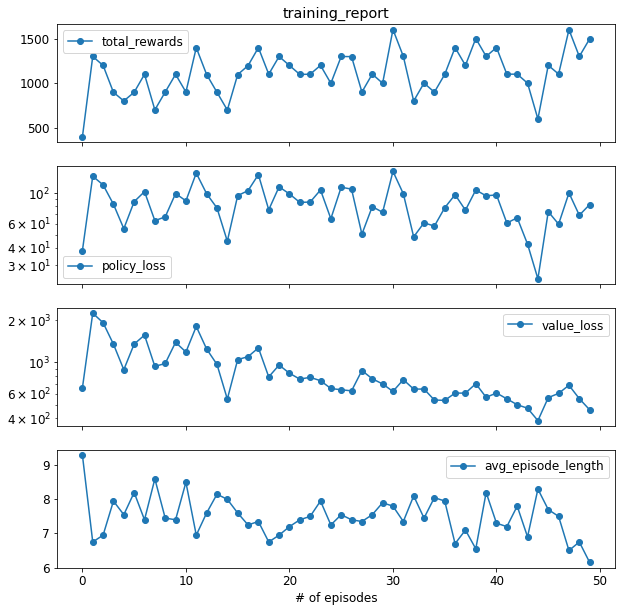

In [8]:
policy = PolicyEstimator(action_dim=action_dim,
                         obs_dim=obs_dim,
                         num_hidden=2,
                         hidden_dim=64,
                         nonlinear_act=nn.ReLU)
value_function = ValueEstimator(action_dim=action_dim,
                                obs_dim=obs_dim,
                                num_hidden=2,
                                hidden_dim=64,
                                nonlinear_act=nn.ReLU)
use_advantage = False
print('using advantage: {}'.format(use_advantage))
algo = REINFORCE(env=env,
                 policy = policy,
                 value_function= value_function,
                 util_compute_policy_loss = util_compute_policy_loss,
                 util_compute_value_loss = util_compute_value_loss,
                 util_compute_advantage = compute_advantages,
                 use_advantage=use_advantage
                )
print('start training')
training_stats = {'total_reward': [],
                'policy_loss': [],
                'value_loss': [],
                'avg_episode_length': []}
num_episodes = 50

if running_as_notebook:
    for i in range(num_episodes):
        paths = algo.collect_paths(process_action=env.truncate_action,
                                    batch_size=20,
                                    max_episode_length=10)
        total_reward, mean_episode_lengths, policy_loss, value_loss = \
                    algo.train_from_episode_batch(i, paths)

        training_stats['total_reward'].append(total_reward)
        training_stats['policy_loss'].append(policy_loss)
        training_stats['value_loss'].append(value_loss)
        training_stats['avg_episode_length'].append(mean_episode_lengths)
    
    clear_output()
    draw_training_stats(training_stats, 'training_report')

In [9]:
if running_as_notebook:
    visualize_policy(reward_function, policy)

### REINFORCE with Advantage Function

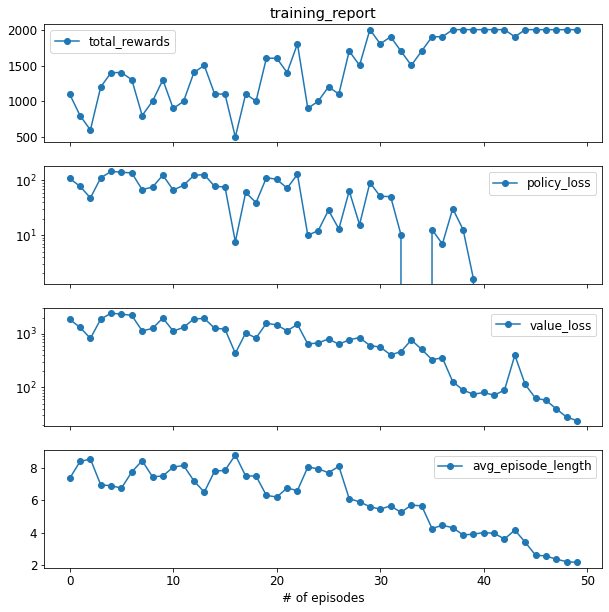

In [10]:
policy = PolicyEstimator(action_dim=action_dim,
                         obs_dim=obs_dim,
                         num_hidden=2,
                         hidden_dim=64,
                         nonlinear_act=nn.ReLU)
value_function = ValueEstimator(action_dim=action_dim,
                                obs_dim=obs_dim,
                                num_hidden=2,
                                hidden_dim=64,
                                nonlinear_act=nn.ReLU)

use_advantage = True
print('using advantage: {}'.format(use_advantage))
algo = REINFORCE(env=env,
                 policy = policy,
                 value_function= value_function,
                 util_compute_policy_loss = util_compute_policy_loss,
                 util_compute_value_loss = util_compute_value_loss,
                 util_compute_advantage = compute_advantages,
                 use_advantage=use_advantage
                )
print('start training')
training_stats = {'total_reward': [],
                'policy_loss': [],
                'value_loss': [],
                'avg_episode_length': []}
num_episodes = 50

if running_as_notebook:
    for i in range(num_episodes):
        paths = algo.collect_paths(process_action=env.truncate_action,
                                    batch_size=20,
                                    max_episode_length=10)
        total_reward, mean_episode_lengths, policy_loss, value_loss = \
                    algo.train_from_episode_batch(i, paths)

        training_stats['total_reward'].append(total_reward)
        training_stats['policy_loss'].append(policy_loss)
        training_stats['value_loss'].append(value_loss)
        training_stats['avg_episode_length'].append(mean_episode_lengths)
    
    clear_output()
    draw_training_stats(training_stats, 'training_report')

In [11]:
if running_as_notebook:
    visualize_policy(reward_function, policy)

Now if you have extra time, you may want to modify the reward function to learn more complicated skills. For example, you may learn the box flipping skill from the force control chapter using REINFORCE method!

# Extra stuff tried:
Make the box upright by giving a large reward when the box angle is more than $\pi/2$.

In [12]:
# def reward_function(observation):
#     """
#     observation = [block_x, block_z, block_theta,
#                    gripper_x, gripper_z, gripper_theta]
#     """
    
#     # compute dense rewards
#     block_angle = observation[2]
#     gripper_angle = observation[5]

#     reward = observation[2]
#     done = False
#     if observation[2] > np.pi/2:
#         done = True
#         reward = 100. # reward goal completion
#     info = {} 
#     return reward, done, info

# # make everything deterministic
# seed = 0
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# env = PlanarGripperGym(render=False,
#                        reward_function=reward_function)
# action_dim = 3
# obs_dim = 6

# policy = PolicyEstimator(action_dim=action_dim,
#                          obs_dim=obs_dim,
#                          num_hidden=2,
#                          hidden_dim=64,
#                          nonlinear_act=nn.ReLU)
# value_function = ValueEstimator(action_dim=action_dim,
#                                 obs_dim=obs_dim,
#                                 num_hidden=2,
#                                 hidden_dim=64,
#                                 nonlinear_act=nn.ReLU)
# use_advantage = False
# print('using advantage: {}'.format(use_advantage))
# algo = REINFORCE(env=env,
#                  policy = policy,
#                  value_function= value_function,
#                  util_compute_policy_loss = util_compute_policy_loss,
#                  util_compute_value_loss = util_compute_value_loss,
#                  util_compute_advantage = compute_advantages,
#                  use_advantage=use_advantage
#                 )
# print('start training')
# training_stats = {'total_reward': [],
#                 'policy_loss': [],
#                 'value_loss': [],
#                 'avg_episode_length': []}
# num_episodes = 200

# if running_as_notebook:
#     for i in range(num_episodes):
#         paths = algo.collect_paths(process_action=env.truncate_action,
#                                     batch_size=20,
#                                     max_episode_length=10)
#         total_reward, mean_episode_lengths, policy_loss, value_loss = \
#                     algo.train_from_episode_batch(i, paths)

#         training_stats['total_reward'].append(total_reward)
#         training_stats['policy_loss'].append(policy_loss)
#         training_stats['value_loss'].append(value_loss)
#         training_stats['avg_episode_length'].append(mean_episode_lengths)
    
#     clear_output()
#     draw_training_stats(training_stats, 'training_report')

In [13]:
# if running_as_notebook:
#     visualize_policy(reward_function, policy)

Weng, L. (2018, April 08). Policy Gradient Algorithms. Retrieved November 19, 2020, from https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `policy_gradient.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.
- Write down your answers to 9.1.c to a separately pdf file and submit it to Gradescope's written submission section. 

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [2 pts] Correct implementation of `util_compute_policy_loss`
- [2 pts] Correct implementation of `util_compute_value_loss`
- [4 pts] Correct implementation of `compute_advantages`

In [14]:
from manipulation.exercises.rl.test_vpg import TestVPG
from manipulation.exercises.grader import Grader 

Grader.grade_output([TestVPG], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 8/8.

Score for Testing advantage function is 4/4.
- tensor(0.)


Score for Testing the policy loss is 2/2.

Score for Testing the value loss is 2/2.
